# Case Study - MAPK
"Signaling switches and bistability arising from multisite phosphorylation in protein kinase cascades", Markevich et al., 2004.

Exercise: See if you can reproduce Figure 3, hysteresis without the steady state assumptions imposed in the subsection "Regulatory properties of a dual phosphorylation– dephosphorylation cycle responsible for bistability".

1. Create the Tellurium simulation model for Fig. 1. What issues with constructing the model from the paper?
1. Evaluate if can reproduce the results in Fig 3 (below) without the steady state constraints.
1. Explore how might address

<img src="figure3.png" width="300">, 

In [17]:
%matplotlib inline
import numpy as np
import model_fitting as mf
import tellurium as te
import matplotlib.pyplot as plt
from collections import namedtuple

## Model
There are some issues with the model in the paper.
1. The paper does not provide a value for $K_{m5}$. So we need to guess.
1. $k_2^{cat}$ is much bigger than the other $k^{cat}$.
1. The rates $v_1$ and $v_2$ do not consider the unphosphorylated state $M$ (in the denominator), whereas $M$ is considered in $v_3$ and $v_4$.

In [39]:
# Tellurium model from the paper
model = """
R1: M -> Mp; (k1_cat * MAPKK*M/k_m1)/(1 + M/k_m1 + Mp/k_m2 )
R2: Mp -> Mpp; (k2_cat * MAPKK*Mp/k_m2)/(1 + M/k_m1 + Mp/k_m2 )
R3: Mpp -> Mp; (k3_cat * MKP*Mpp/k_m3)/(1 + Mpp/k_m3 + Mp/k_m4 + M/k_m5)
R4: Mp -> M; (k4_cat * MKP*Mp/k_m4)/(1 + Mpp/k_m3 + Mp/k_m4 + M/k_m5)


M = 500;
Mp = 0;
Mpp = 0;
k1_cat = 0.01
k2_cat = 15;
k3_cat = 0.084;
k4_cat = 0.06
k_m1 = 50;
k_m2 = 500;
k_m3 = 22;
k_m4 = 18;
k_m5 = 15;  # Not specified in model
MAPKK = 50;
MKP = 100;
"""
rr = te.loada(model)

## Dynamics of the model in the paper.
Look at Mpp for different values of MAPKK.

In [40]:
# This function allows us to explore the effects of one model parameter
def plotParameterDynamics(name, values, others_dict={}, sim_time=4000):
    for value in values:
        parameters = mf.makeParameters([name], values=[value], maxs=[value] )
        for other_name in others_dict.keys():
            other_value = others_dict[other_name]
            parameters.add(other_name, value=other_value, min=other_value*0.99, max=other_value*1.01)
        data = mf.runSimulation(parameters=parameters, model=model, sim_time=sim_time, num_points=100)
        plt.plot(data[:,0], data[:,1:])
        plt.legend(['M', 'Mp', 'Mpp'])
        plt.title("%s=%f" % (name, float(value)))
        plt.show()

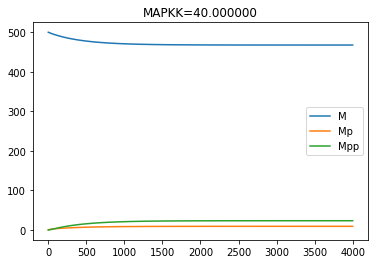

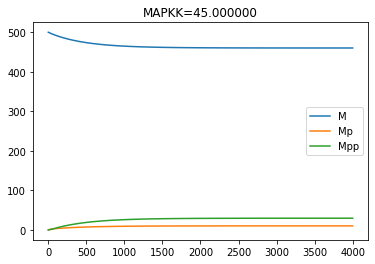

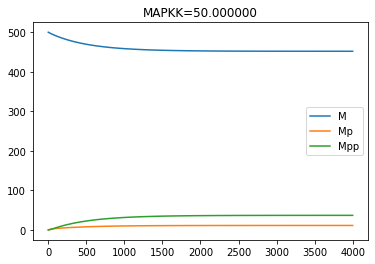

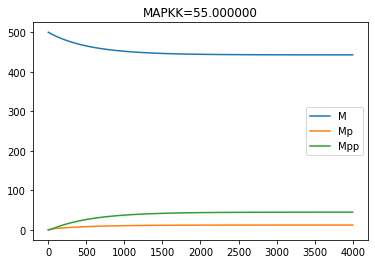

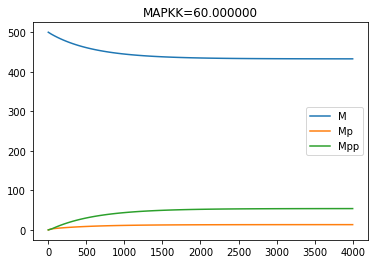

In [38]:
plotParameterDynamics('MAPKK', [40, 45, 50, 55, 60])

It seems that the steady state of Mpp increases linearly with MAPKK. We can confirm this by explicitly looking at the steady state.

In [21]:
SteadyState = namedtuple("SteadyState", "M Mp Mpp")
def reportSteadyState(name, values, others_dict={}, sim_time=5000):
    result = {}
    for value in values:
        parameters = mf.makeParameters([name], values=[value], maxs=[value] )
        for other_name in others_dict.keys():
            other_value = others_dict[other_name]
            parameters.add(other_name, value=other_value, min=other_value*0.99, max=other_value*1.01)
        data = mf.runSimulation(parameters=parameters, model=model, sim_time=sim_time, num_points=2)
        steady_state = SteadyState(M=data[-1,1], Mp=data[-1, 2], Mpp=data[-1, 3])
        result[value] = steady_state
    return result

In [41]:
reportSteadyState('MAPKK', [40, 45, 48, 50, 52, 55, 60])

{40: SteadyState(M=23.532946811045584, Mp=9.106561841429198, Mpp=467.3604907303001),
 45: SteadyState(M=14.778698042787841, Mp=7.343642833734888, Mpp=477.87765816988843),
 48: SteadyState(M=12.054298995158385, Mp=6.656060740437132, Mpp=481.28963904670775),
 50: SteadyState(M=10.683674244872316, Mp=6.277612007073259, Mpp=483.0387118058179),
 52: SteadyState(M=9.5581786960194, Mp=5.946695989406321, Mpp=484.4951230672244),
 55: SteadyState(M=8.204336319557598, Mp=5.519585836637106, Mpp=486.27607518579606),
 60: SteadyState(M=6.550254728092759, Mp=4.943193193140425, Mpp=488.50654987111494)}

# Effect of issues in the model?
1. $K_{m5}$ is unspecified. Maybe, we need the right value?
1. $k^{cat}_2$ is much larger than the other $k^{cat}$. A typo?
1. The rates $v_1$, $v_2$ don't consider the unphosphorylated state M.

### $K_{m5}$

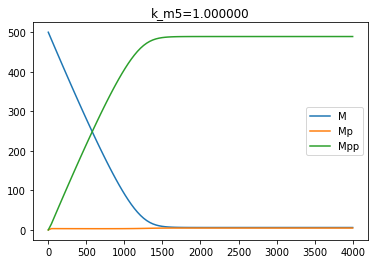

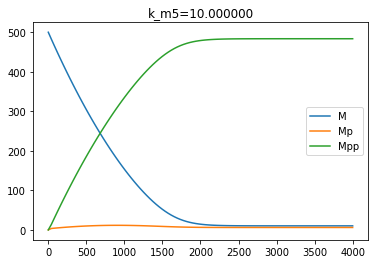

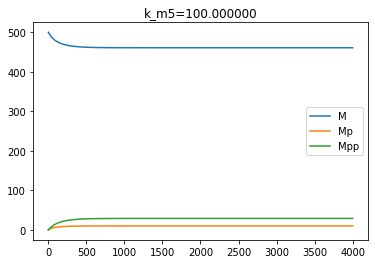

In [5]:
plotParameterDynamics('k_m5', [1, 10, 100])

It's possible that $K_{m5} \approx 10$ might produce interesting dynamics.

### $k^{cat}_2$

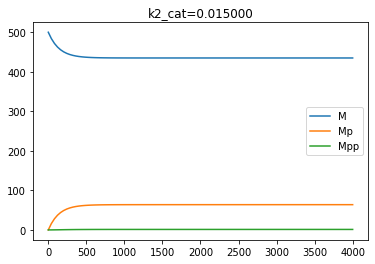

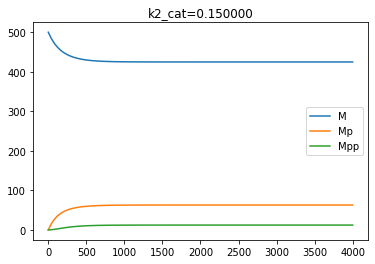

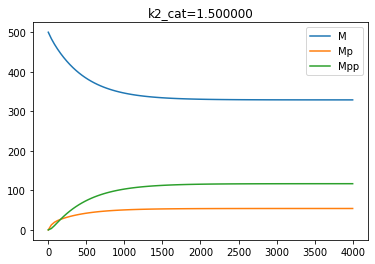

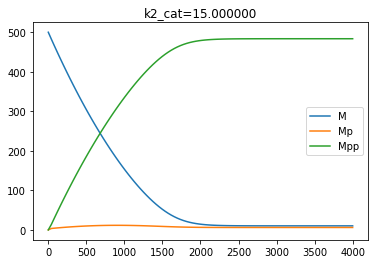

In [16]:
plotParameterDynamics('k2_cat', [0.015, 0.15, 1.5, 15], others_dict={"k_m5": 10, "MAPKK": 50})

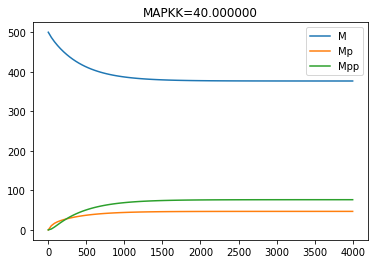

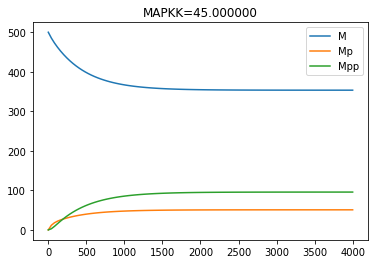

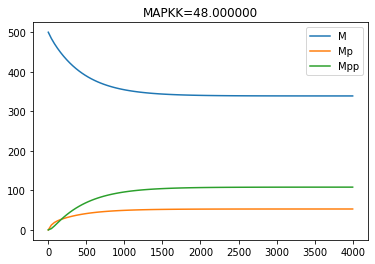

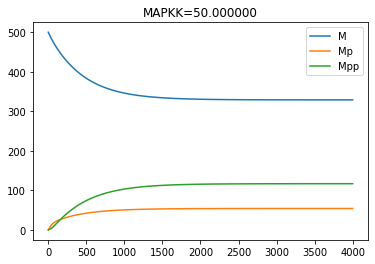

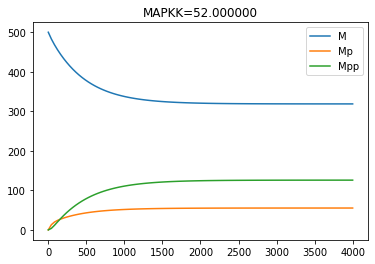

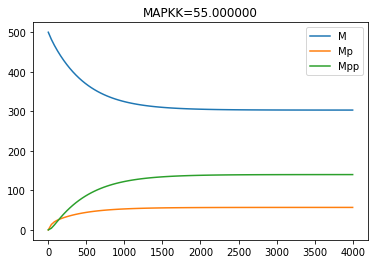

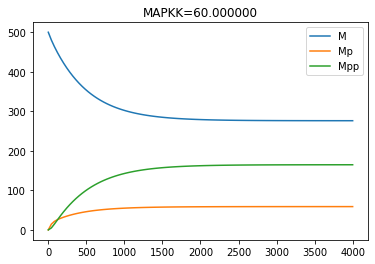

In [7]:
plotParameterDynamics('MAPKK', [40, 45, 48, 50, 52, 55, 60], others_dict={"k_m5": 10, "k2_cat": 1.5})

# Obtaining Steady State Values

In [8]:
# Ideally, we get steady state directly. But this fails. So, may need just to run the simulation long enough.
parameters = mf.makeParameters(['MAPKK'], values=[50] )
road_runner = mf.makeSimulation(parameters=parameters, model=model)
try:
    print(road_runner.getSteadyStateValues())
except Exception as e:
    print(e)



Jacobian matrix singular in NLEQ. Failed to converge to steady state. Check if Jacobian matrix is non-invertible or steady state solution does not exist.


In [9]:
# Instead, run the simulation for long enough and pick up the end values.